In [2]:
#imports
import os
import pickle
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import enlighten

from IPython.core.display import HTML
from IPython.display import SVG, Image, display

#RDKit related imports
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import Draw
from rdkit import DataStructs

#scikit imports
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV



#tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf

RDLogger.logger().setLevel(RDLogger.CRITICAL)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
from datetime import datetime

In [4]:
now = datetime.now()

dform = now.strftime('%y%m%d')

In [5]:
def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))


In [6]:
cols = pd.read_csv('backup_df.csv', nrows=1).columns
dataframe = pd.read_csv('backup_df.csv', index_col=False, usecols=cols[1:])

In [ ]:
PandasTools.AddMoleculeColumnToFrame(dataframe, 'PUBCHEM_CANONICAL_SMILES', 'ROMol', includeFingerprints=True)

In [8]:
RF_dataset = dataframe.copy()

In [9]:
PandasTools.RemoveSaltsFromFrame(RF_dataset)

In [10]:
RF_dataset['Active'] = np.NaN

In [11]:
for index, row in RF_dataset.iterrows():
    activity = row.PUBCHEM_ACTIVITY_OUTCOME
    if activity == 'Active':
        RF_dataset.loc[index, 'Active'] = 1
    else:
        RF_dataset.loc[index, 'Active'] = 0

In [12]:
RF_dataset['Active'] = RF_dataset['Active'].astype(int)

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_CANONICAL_SMILES,ROMol,Active
0,1511,56314828,1988,Inactive,0,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,0
1,1511,56321651,425322,Inactive,0,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,0
2,1511,56322145,24981957,Inactive,0,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,0

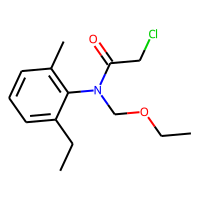
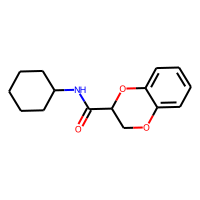
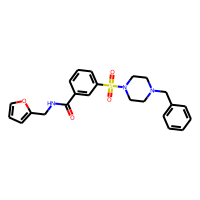

In [13]:
show(RF_dataset.head(3))

In [14]:
#get fingerprints etc
activity_binary = []
ECFP6s = []
topols = []
atom_pairs = []



pbar = enlighten.Counter(total=len(RF_dataset.index), desc='Calculating molecular descriptors', unit='ticks')

for ID, row in RF_dataset.iterrows():
    # print(i)

    mol = row.ROMol# if i == max_radius else row[f'FRAG_R{i}']          

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=2048)

    ECFP6s.append(ECFP6_vec)
    topols.append(topol_vec)
    atom_pairs.append(atpair_vec)



    # print(descriptor)
    activity_binary.append(row.PUBCHEM_ACTIVITY_OUTCOME)
    pbar.update()


In [15]:
length = len(ECFP6s)

if all(len(lst) == length for lst in [ECFP6s, topols, atom_pairs]):
    print('Lists are equal in length')
else:
    print('Lists are unequal in length')

Lists are equal in length


In [16]:
#convert to numpy
ECFP6s_np = []
topols_np = []
atom_pairs_np = []

for i in range(len(ECFP6s)):
    ecfp_arr = np.zeros((1,))
    topol_arr = np.zeros((1,))
    atpair_arr = np.zeros((1,))


    ecfp = ECFP6s[i]
    topol = topols[i]
    atompair = atom_pairs[i]

    DataStructs.ConvertToNumpyArray(ecfp, ecfp_arr)
    DataStructs.ConvertToNumpyArray(topol, topol_arr)
    DataStructs.ConvertToNumpyArray(atompair, atpair_arr)

    ECFP6s_np.append(ecfp_arr)
    topols_np.append(topol_arr)
    atom_pairs_np.append(atpair_arr)


In [17]:
x_ecfp6 = ECFP6s_np
x_topols = topols_np
x_atpairs = atom_pairs_np

In [18]:
y = RF_dataset.Active

In [19]:
y.shape

(305679,)

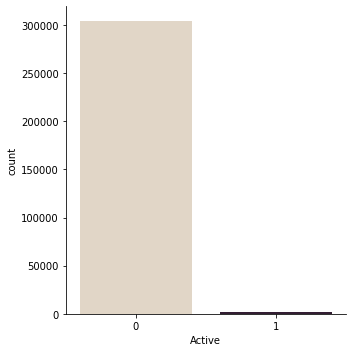

In [20]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

count_acts = sns.catplot(x='Active', kind="count", palette="ch:.25", data=RF_dataset)

In [21]:
# x_ecfp6_ada, y_ecfp6_ada = ADASYN().fit_resample(x_ecfp6[:1000], y[:1000])
# ecfp6_sample_count = sorted(Counter(y_ecfp6_ada).items())

In [22]:
# #Oversampling with ADASYN

# x_ecfp6_ada, y_ecfp6_ada = ADASYN().fit_resample(x_ecfp6, y)
# ecfp6_sample_count = sorted(Counter(y_ecfp6_ada).items())


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import History, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [24]:
# y_ten = tf.constant(y)

In [25]:
ecfp_ten = tf.constant(ECFP6s_np)


2022-09-09 15:00:05.362701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:00:05.440631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:00:05.440766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:00:05.442116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
#normaliser?
#probably not usable for fingerprints
#
# normaliser = Normalization(axis=-1)
# normaliser.adapt(x_ecfp6)
# normaliser.mean.numpy()

In [9]:
h = History()
red_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, min_delta=1e-5)

In [10]:
#TF binary classification

def create_model(inp):

    optimiser = Adam(learning_rate=0.005)
    model = Sequential()
    # model.add(normaliser)
    model.add(Dense(60, input_shape=(inp.shape[1],), activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(60, input_shape=(inp.shape[1],), activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))


    model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

In [29]:
ecfp6_mod = create_model(ecfp_ten)


In [30]:
ecfp6_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                122940    
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 126,661
Trainable params: 126,661
Non-trainable params: 0
_________________________________________________________________


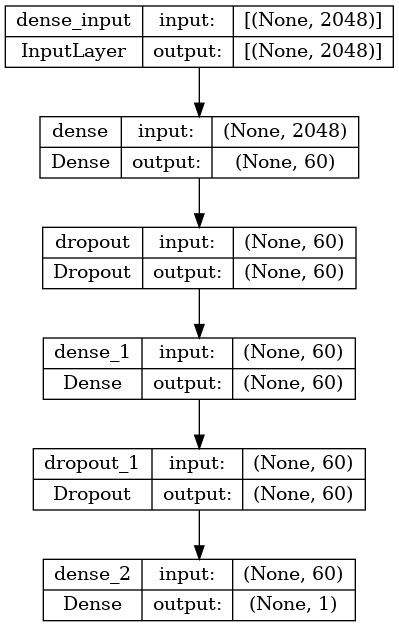

In [31]:
image_model = tf.keras.utils.plot_model(ecfp6_mod, "RNN_de_novo_generator.png", show_shapes=True)
display(Image(filename="RNN_de_novo_generator.png"))

In [32]:
ecfp6_mod.fit(
    x=ecfp_ten,
    y=y,
    epochs=200,
    verbose='auto',
    callbacks = [h, red_LR],
    validation_split=0.2,
)

2022-09-09 15:00:27.890325: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4006592512 exceeds 10% of free system memory.


Epoch 1/200
 123/7642 [..............................] - ETA: 9s - loss: 0.0573 - binary_accuracy: 0.9931  

2022-09-09 15:00:30.406096: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7642/7642 [==============================] - 12s 1ms/step - loss: 0.0364 - binary_accuracy: 0.9947 - val_loss: 0.0299 - val_binary_accuracy: 0.9957 - lr: 0.0050
Epoch 2/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0298 - binary_accuracy: 0.9949 - val_loss: 0.0273 - val_binary_accuracy: 0.9955 - lr: 0.0050
Epoch 3/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0281 - binary_accuracy: 0.9952 - val_loss: 0.0280 - val_binary_accuracy: 0.9957 - lr: 0.0050
Epoch 4/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0273 - binary_accuracy: 0.9955 - val_loss: 0.0324 - val_binary_accuracy: 0.9956 - lr: 0.0050
Epoch 5/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0246 - binary_accuracy: 0.9957 - val_loss: 0.0279 - val_binary_accuracy: 0.9957 - lr: 0.0050
Epoch 6/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0237 - binary_accuracy: 0.9959 - val_loss: 0.0288 - val_binary_accu

In [11]:
model_dir = os.path.join(os.getcwd(), 'models')

try:
    os.mkdir(model_dir)
except FileExistsError:
    print("Directory exists")

Directory exists


In [ ]:
ecfp6mod_name = os.path.join(model_dir, f'BASE_ecfp6_model')
ecfp6_mod.save(ecfp6mod_name)

In [13]:
ada_x_mmap = np.load('./adasyn/x_ecfpada.npy', mmap_mode='r')
ada_y_mmap = np.load('./adasyn/y_ecfpada.npy', mmap_mode='r')


In [14]:
from custom_generator import data_generator

In [15]:
batch_size = 2000
dim = ada_x_mmap.shape
classes = 2

In [16]:
training_generator = data_generator(ada_x_mmap, ada_y_mmap, dim, batch_size, n_channels=classes)

In [19]:
ADA_ecfp6_mod = create_model(ada_x_mmap)

In [20]:
ADA_ecfp6_mod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                122940    
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 126,661
Trainable params: 126,661
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ADA_ecfp6_mod.fit_generator(
    generator=training_generator,
    use_multiprocessing=True,
    workers=6,
)

In [9]:
# print(ada_y_count)

422064


In [30]:
euos_path = os.path.join(os.getcwd(), 'Pilot_08_09_2021.sdf')

EUOS_db = PandasTools.LoadSDF(euos_path)

In [31]:
len(EUOS_db.index)

4927

In [32]:
EU_OS_ECFP6s = []
EU_OS_topols = []
EU_OS_atom_pairs = []

euos_pbar = enlighten.Counter(total=len(EUOS_db.index), desc='Encoding EU-OS bioactives', unit='ticks')

for ID, row in EUOS_db.iterrows():
    mol = row.ROMol

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

    EU_OS_ECFP6s.append(ECFP6_vec)
    EU_OS_topols.append(topol_vec)
    EU_OS_atom_pairs.append(atpair_vec)

    euos_pbar.update()


In [35]:
#predict actives ecfp6
ten_EU_OS_ecfp6s = tf.constant(EU_OS_ECFP6s)

ecfp6_out = ecfp6_mod.predict(ten_EU_OS_ecfp6s)


154/154 [==============================] - 0s 660us/step


In [36]:
EUOS_db['ECFP6_Model'] = ecfp6_out

,Supplier,Supplier_ID,ID,ROMol,ECFP6_Model
3063,MolPort,MolPort-003-983-625,EOS100600,,1.0
4415,MolPort,MolPort-002-553-776,EOS101952,,1.0

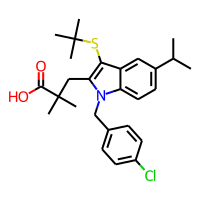
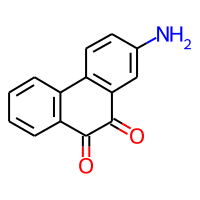

In [41]:
show(EUOS_db.sort_values(by=['ECFP6_Model'], ascending=False).head(2))

In [42]:
ecfp6_outdf = EUOS_db.drop('ROMol', axis=1)

In [ ]:
ecfp6_outdf.to_csv('EU_OS_predictions.csv')